In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as utils
import matplotlib.pyplot as plt
import numpy as np 
from tqdm import tqdm
import cv2
from torch.utils.data import TensorDataset, DataLoader


100%|██████████| 286/286 [00:05<00:00, 48.48it/s]
/var/folders/nq/f_nplzp52qx_hrrhyg44xf4c0000gn/T/ipykernel_7736/2025793353.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_data_cmp,  y_data_cmp = np.array(x_data_cmp), np.array(y_data_cmp)
/var/folders/nq/f_nplzp52qx_hrrhyg44xf4c0000gn/T/ipykernel_7736/2025793353.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_data_icdar, y_data_icdar = np.array(x_data_icdar), np.array(y_data_icdar)


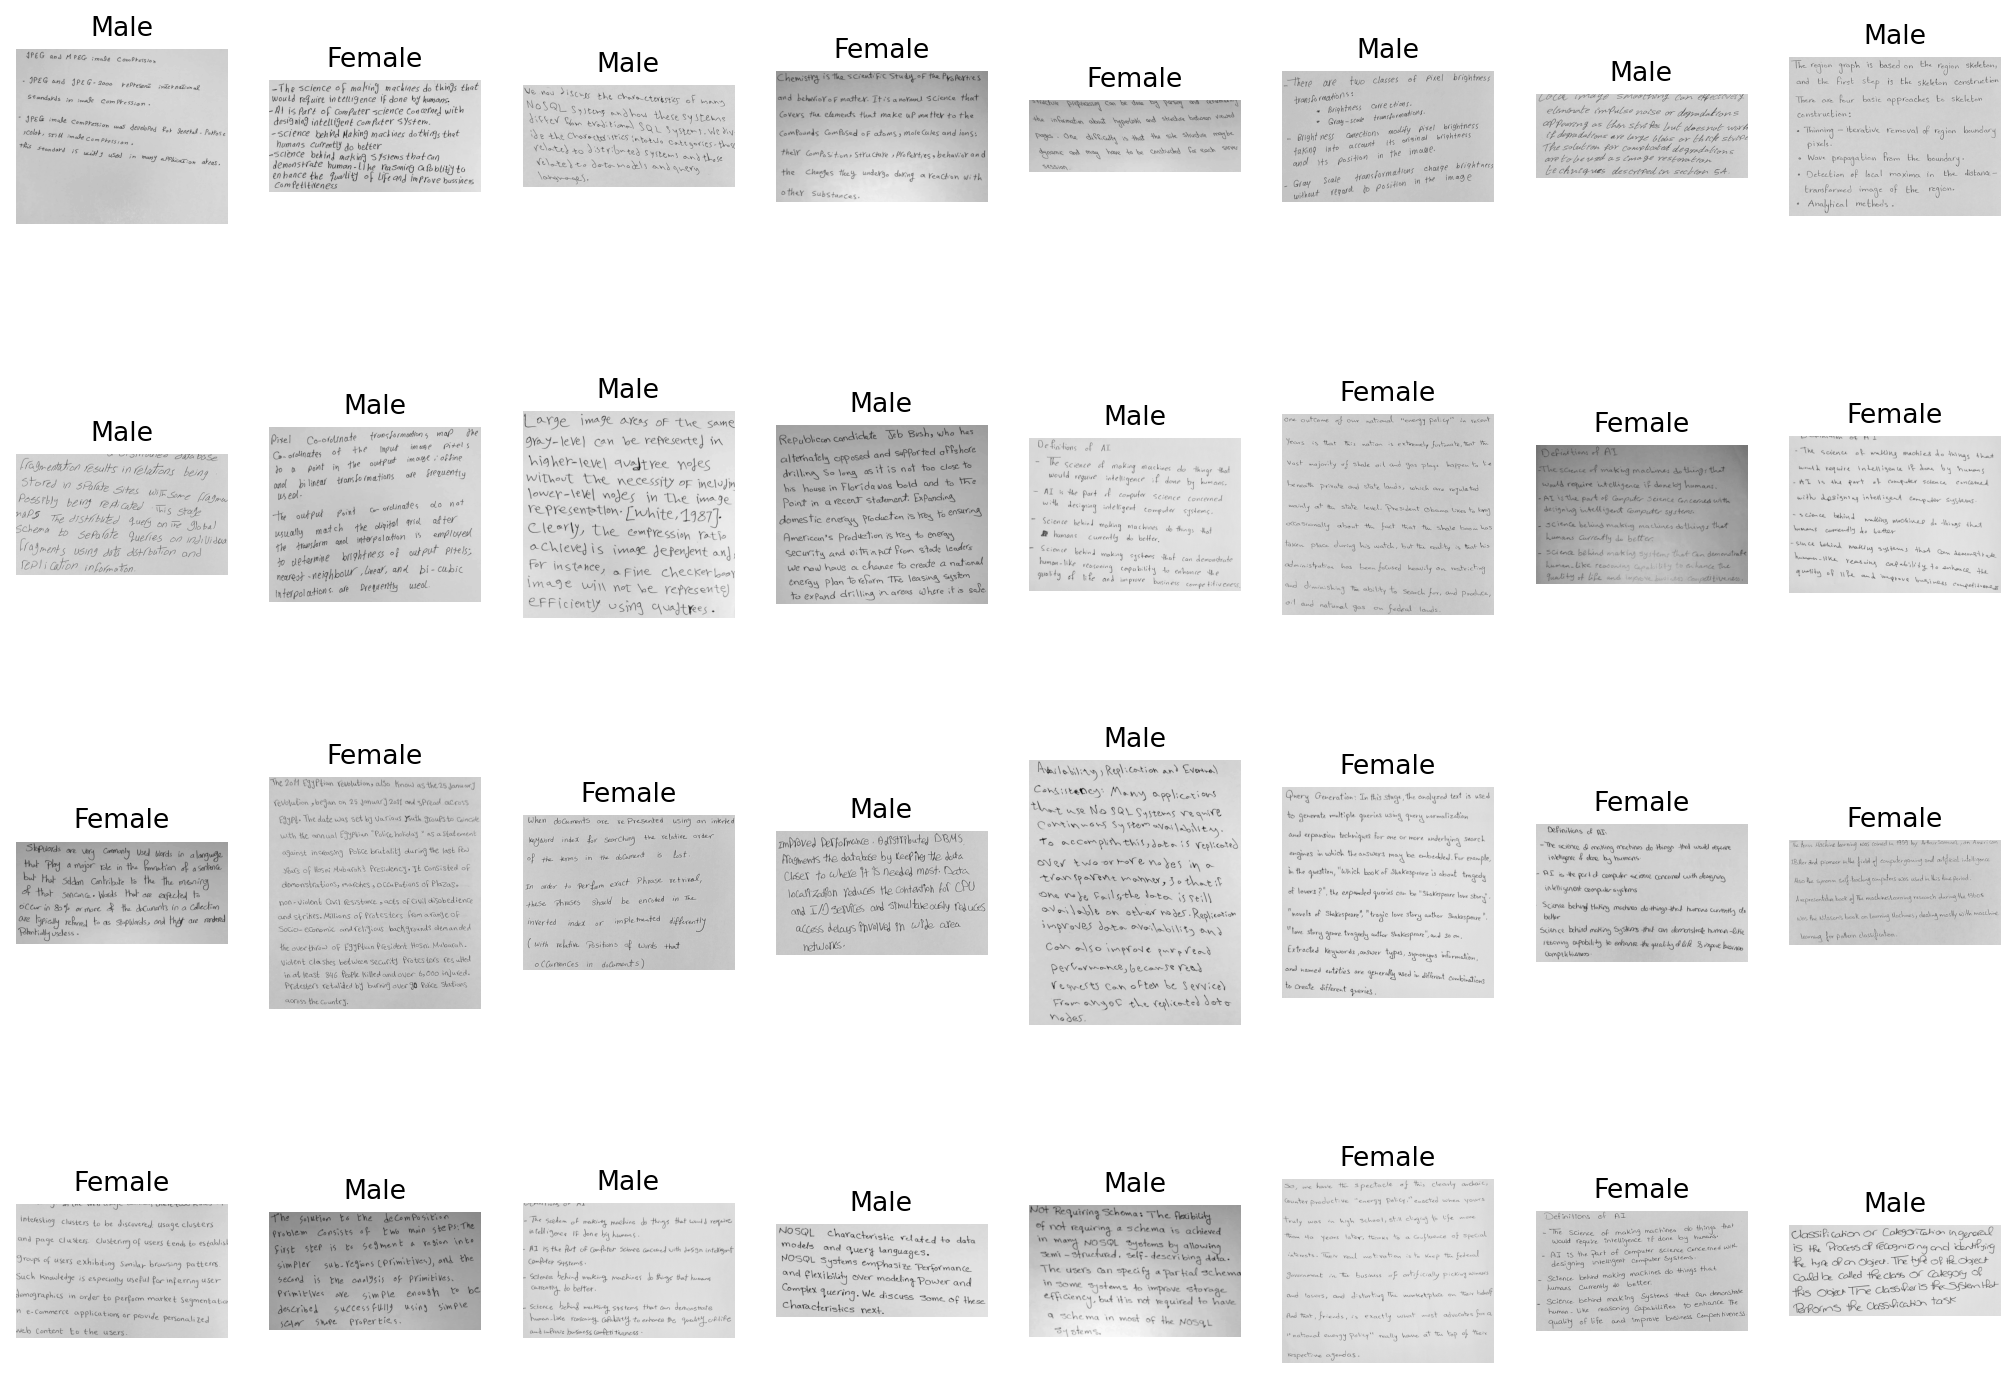

 length of training set is 836
 length of validation set is 91
(836,) (836,)


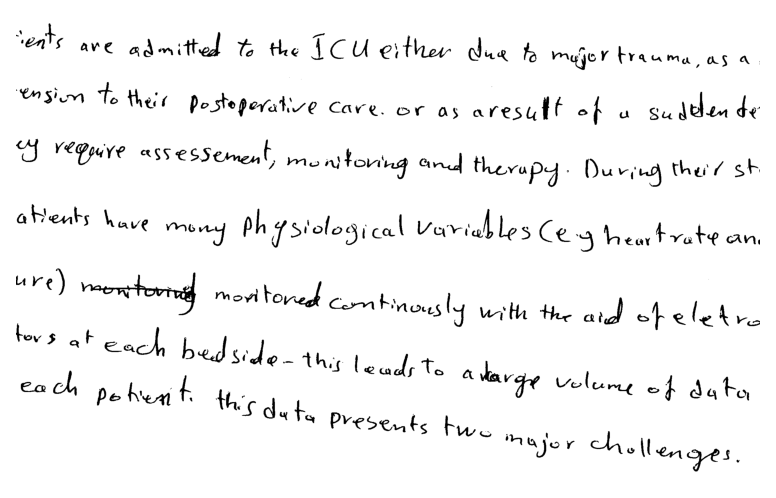

/var/folders/nq/f_nplzp52qx_hrrhyg44xf4c0000gn/T/ipykernel_7736/3124958163.py:33: RuntimeWarning: divide by zero encountered in log
  coeffs = np.polyfit(np.log(box_sizes), np.log(partial_box_counts), 1)


 At 0.9988038277511961343(836, 12) (836,)


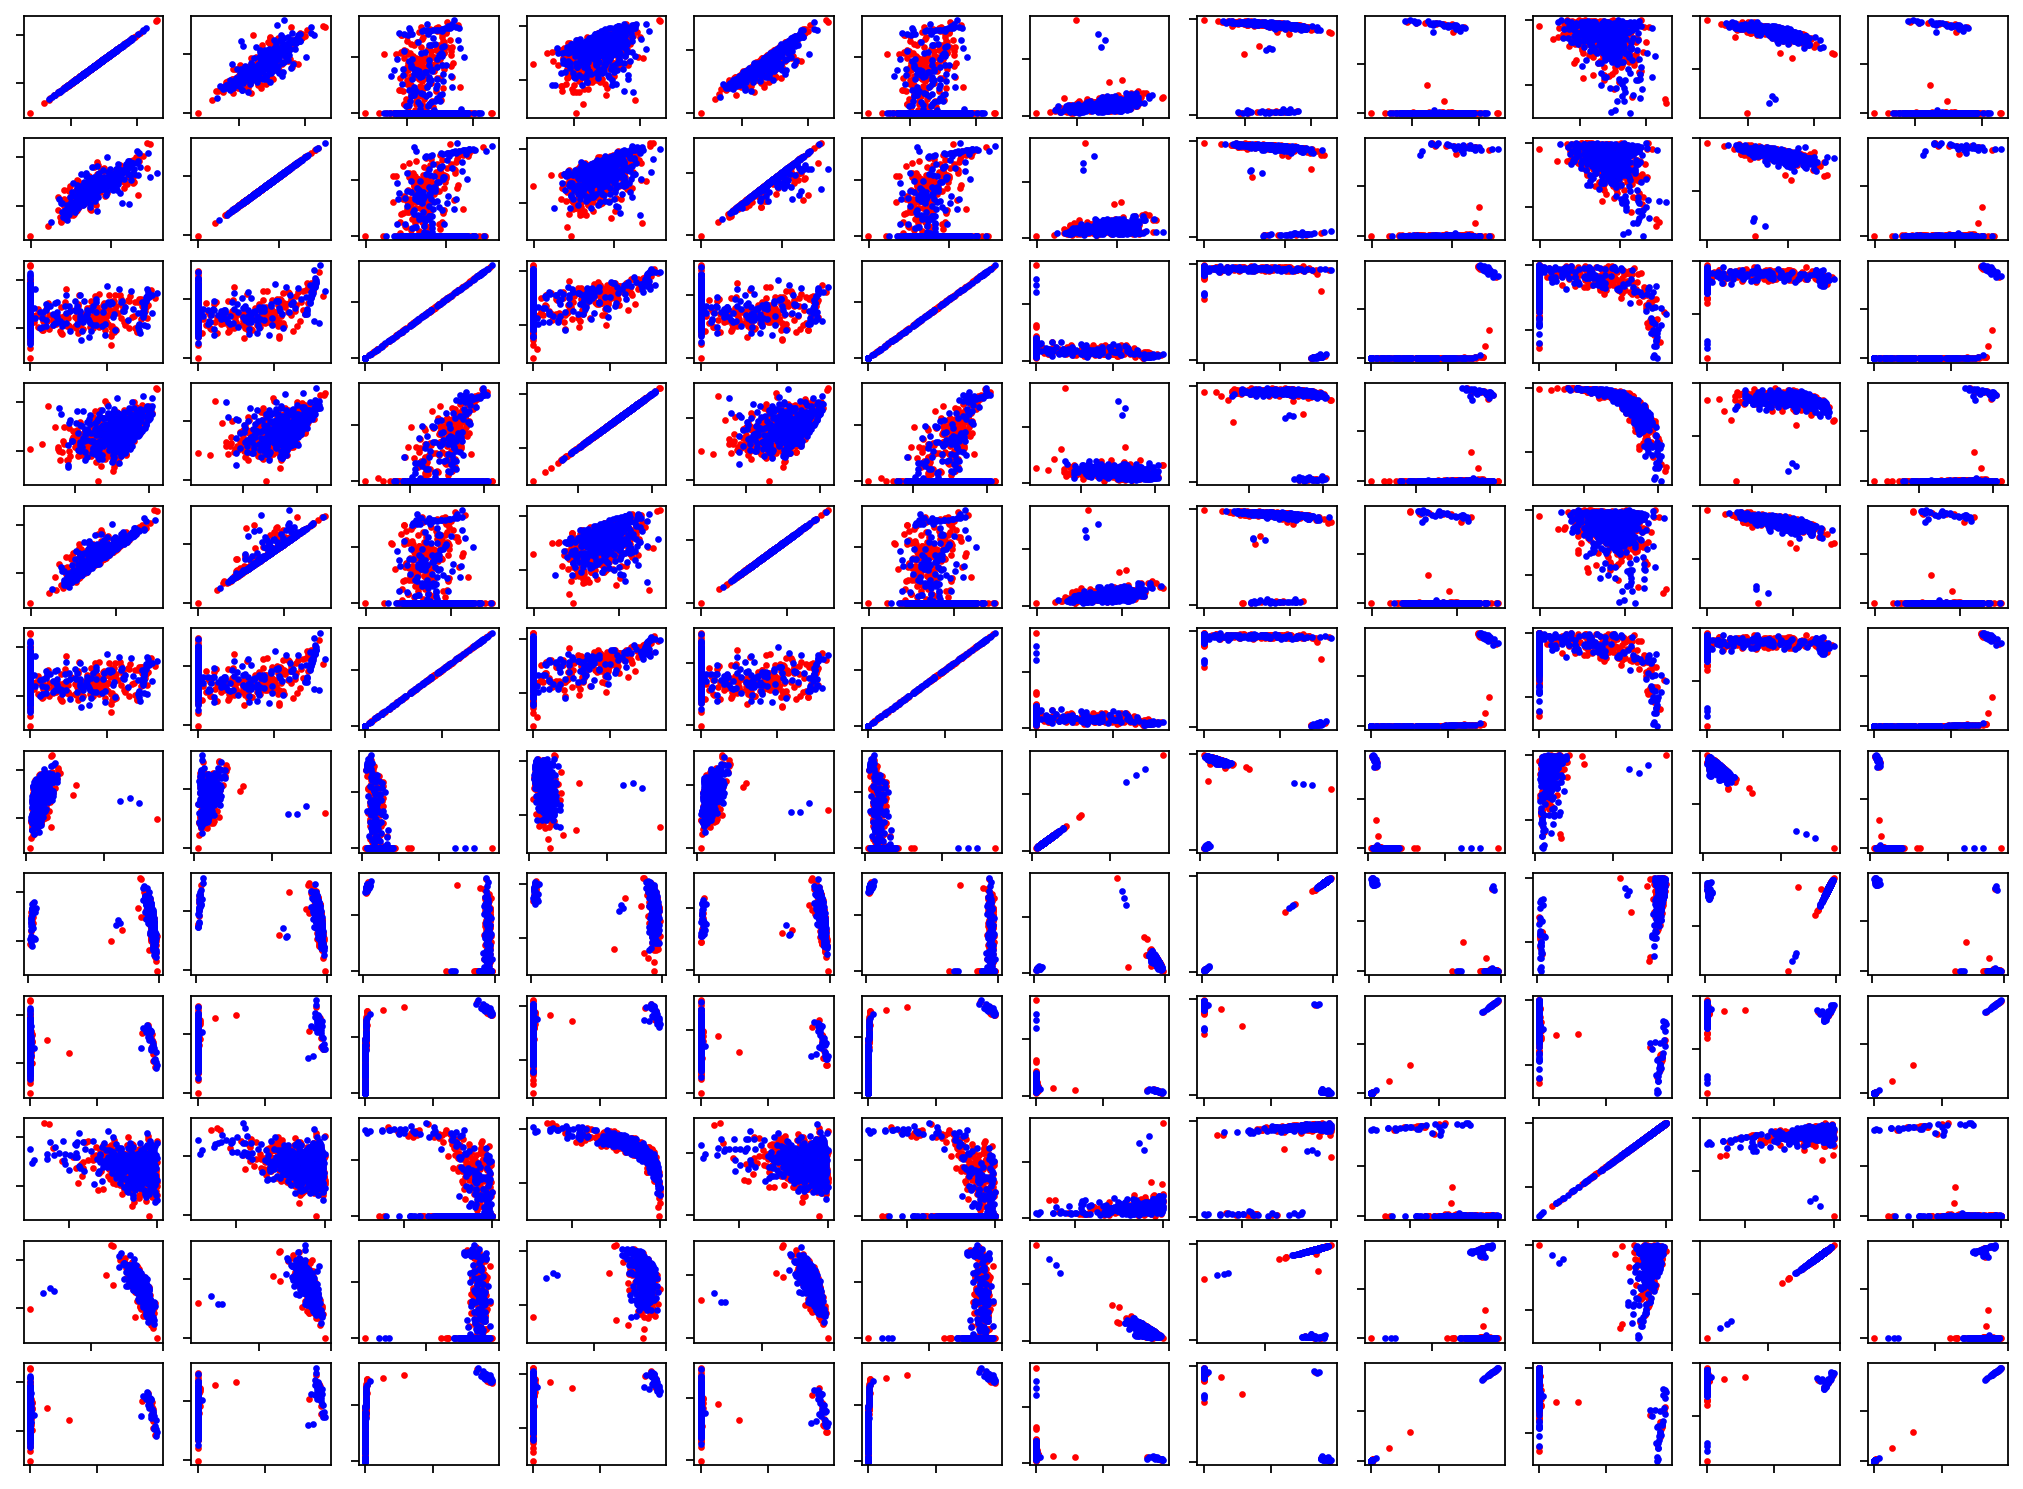

/var/folders/nq/f_nplzp52qx_hrrhyg44xf4c0000gn/T/ipykernel_7736/2694488313.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


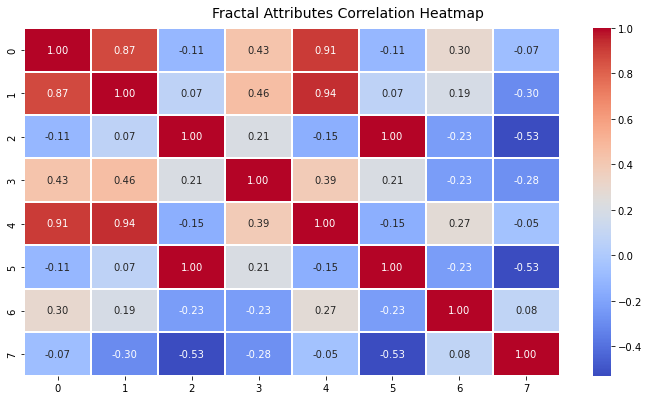

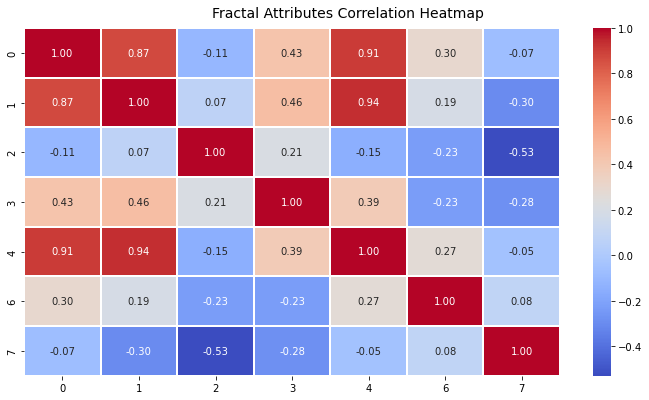

In [4]:
%run FindFractalFeatures.ipynb
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
#img_size = 400
N, H, K = x_train.shape[1], 400, 2      # No. of input features (input layer size), hidden layer size, No. of classes (output layer size)
num_epochs, batch_size = 2, 100
learning_rate = 0.003



In [5]:
def prepare_dataset(x_train, y_train, x_test, y_test):
    x_train = torch.Tensor(x_train) # transform to torch tensor
    y_train = torch.Tensor(y_train) # transform to torch tensor
    y_train = y_train.type(torch.LongTensor)
    x_test = torch.Tensor(x_test) # transform to torch tensor
    y_test = torch.Tensor(y_test) # transform to torch tensor
    y_test = y_test.type(torch.LongTensor)

    print(x_train.shape)
    print(x_test.shape)
    train_dataset = TensorDataset(x_train, y_train)
    test_dataset = TensorDataset(x_test, y_test)

    # Data loader: now they are converted to batches of [batch_size, 1, P, P]
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


    return train_loader, test_loader

train_loader, test_loader = prepare_dataset(x_train, y_train, x_test, y_test)
    

torch.Size([836, 12])
torch.Size([91, 12])


In [6]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, N, H, K):                    # Give the model the no. of neurons in the input, hidden and output layers
        super(NeuralNet, self).__init__()

        self.netLayers= nn.Sequential(
        nn.Linear(N, H), nn.ReLU(),                 # First hidden Layer             
        nn.Linear(H, K)                             # Output Layer
        )

        self.N = N
        # Loss and optimizer
        self.criterion = nn.CrossEntropyLoss()      # Loss function
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)  # To minimize loss
       
    def forward(self, x):
        logits = self.netLayers(x)
        return logits

    def train(self, num_epochs, train_loader):
        for epoch in range(num_epochs):
            for  (features, labels) in tqdm(train_loader):  #each batch is a tuple of features and their corresponding labels.
                
                features = features.to(device)        # from [batch_size, 1, P, P] to [batch_size, P**2]
                labels = labels.to(device)                      # [batch_size] : Dataset labels of current batch
                
                # Forward pass
                logits = self(features)                          # Propagate the batch: gives output [batch_size, K] 
                loss = self.criterion(logits, labels)          # Calculate the loss (uses Softmak on the outputs along the way)
                
                # Backward Pass
                self.optimizer.zero_grad()                     # Clear the gradients for all network parameters (e.g. due to a previous batch)
                loss.backward()                                # Accumulate all the gradients due to the current batch
                self.optimizer.step()                          # Update the network's weights and biases
                
        
    
    def test(self, train_loader):
        with torch.no_grad():
            n_correct = 0
            n_correct_rand = 0
            for test_features, test_labels in train_loader:
                test_features = test_features.to(device)     # Flattening the image first
                test_labels = test_labels.to(device)
                logits = self(test_features)                                 # Propagate the test batch
                predicted = logits.argmax(1)                    #the highest logit is also the highest softmax probability. This has shape (batch_size,)
                n_correct += (predicted == test_labels).sum().item()

                random_guess = torch.from_numpy(np.random.randint(0,2,len(predicted)))
                n_correct_rand += (random_guess == test_labels).sum().item()

            acc = 100.0 * n_correct / (len(train_loader) * batch_size)
            acc_rand = 100.0 * n_correct_rand / (len(train_loader) * batch_size)
            print(f'Model Accuracy is at {acc} and Random Guessing Accuracy is at {acc_rand} %')
    


In [7]:
def predict_gender(handwriting, saved=False):
    model = NeuralNet(N, H, K).to(device)      #so it's done on the GPU if available.

    # Load or Train the model
    if saved:
        model.load_state_dict(torch.load('./Intelligence/GenderIntelligence.pth'))
    else:
        train_loader, test_loader = prepare_dataset(x_train, y_train, x_test, y_test)                            # Prepare dataset
        model.train(num_epochs, train_loader)                                    # Train the model
        model.test(test_loader)                                                  # Test the model
        torch.save(model.state_dict(), './Intelligence/GenderIntelligence.pth')

    if(handwriting):
       pass
    return ''


In [8]:
predict_gender('');

torch.Size([836, 12])
torch.Size([91, 12])


100%|██████████| 9/9 [00:00<00:00, 626.21it/s]

Model Accuracy is at 52.0 and Random Guessing Accuracy is at 39.0 %
